In [1]:
# 💡 NOTE: Runs this jupyter notebook from the projects root, mimicking a root run.
import os
# ⭐️ NOTE: Set num_to_move to how many directories it takes from this file to reach project root.
num_to_move = 2
os.chdir(os.getcwd().rsplit("/", num_to_move)[0])
print("RUNNING FROM: ->>",os.getcwd())

import torch
# # Show all values when printing torch tensors.
torch.set_printoptions(threshold=torch.inf) # shows all the values when printing tensors


# Reloads external functions when its code changes into this notebook.
%load_ext autoreload
%autoreload 1
# %aimport will only reload those files
# %aimport utils.bboxes

RUNNING FROM: ->> /Users/tonyavis/Main/AI_public_projects/object_detection/yolo_v1_orig


## Test Model Checkpoints On Images

### Load Model

In [2]:
from model.model_utils import load_checkpoint
%aimport model.model_utils
from configs.config_loader import load_config
%aimport configs.config_loader

In [3]:
import torch.optim as optim
from model.yolov1 import YOLOv1
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR


In [4]:
cfg = load_config("config_voc_dataset.yaml")
yolo = YOLOv1(cfg=cfg, in_channels=3).to(cfg.DEVICE)
optimizer = optim.Adam(yolo.parameters(), lr=cfg.LEARNING_RATE)

warm_up = LinearLR(  # warmups help prevent exploding gradients early on.
    optimizer=optimizer, start_factor=0.1, total_iters=5
)  # 10% of LR over first 5 epochs, then back to regular LR.

cosine = CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS - 5)
scheduler = SequentialLR(  # If debugging set scheduler = None to remove schedulers.
    optimizer,
    schedulers=[warm_up, cosine],
    milestones=[5],  # <== switch from warm_up to cosine after epoch 5
)

In [5]:
model = load_checkpoint(cfg, yolo, optimizer, scheduler)


################################################################ 

Loading model Checkpoint | model_name: ttoverfit_one_image_yolo_v1_dataset_VOCDataset_date_2025-07-19_EPOCH_100_LOSS_1.5732_SIZE_448.pt


 Saved Model Attributes:
  epoch      → 100
  model      → dict with 148 entries
  optimizer  → dict with 2 entries
  scheduler  → None
  mean_loss  → 1.573216438293457

√ Loaded model.

################################################################ 



### Load an Image

In [6]:
from data.voc_dataset import VOCDataset
from data.utils.setup_transforms import setup_transforms

In [7]:
t = setup_transforms(cfg.IMAGE_SIZE)
d = VOCDataset(cfg, which_dataset=cfg.TRAIN_DIR_NAME, transforms=t)

In [8]:
img_tensor, label = d.__getitem__(0)

### Predict

In [9]:
# Add a batch to the image and move it to GPU
pred = yolo(img_tensor.unsqueeze(0).to(cfg.DEVICE))

In [10]:
# reshape pred 1 is batch_size
pred = pred.view(1, cfg.S, cfg.S, cfg.CELL_NODES)
pred.shape

torch.Size([1, 7, 7, 30])

### Extract Bounding Boxes and Perform NMS

In [11]:
from utils.nms import nms
%aimport utils.nms
from data.utils.bbox_utils import extract_and_convert_pred_bboxes
%aimport data.utils.bbox_utils

In [12]:
pred_bboxes = extract_and_convert_pred_bboxes(cfg=cfg, pred=pred)
pred_bboxes.shape

torch.Size([98, 7])

In [13]:
nms_bboxes = nms(cfg, pred_bboxes)
nms_bboxes.shape

torch.Size([1, 7])

### Plot

In [14]:
import torchvision.transforms as transforms

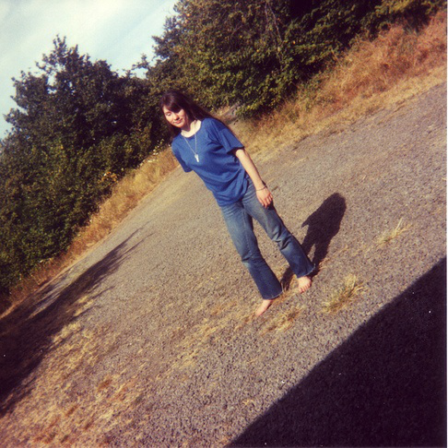

In [15]:
to_pil = transforms.ToPILImage() # convert tensor to PIL Image
pil_image = to_pil(img_tensor)
pil_image

In [16]:
from PIL import Image, ImageDraw

# Define a list of 20 colors one for each class.
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
    (255, 0, 255), (128, 0, 128), (192, 192, 192), (128, 128, 128), (128, 0, 0), (128, 128, 0),
    (0, 128, 0), (0, 128, 128), (0, 0, 128), (255, 165, 0),
    (255, 215, 0), (173, 255, 47), (255, 20, 147), (0, 250, 154), (70, 130, 180)
]

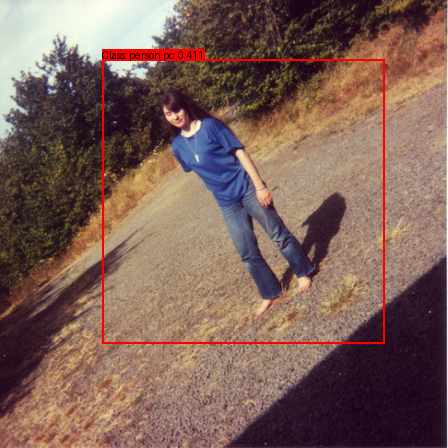

In [17]:
copy_image = pil_image
draw = ImageDraw.Draw(copy_image)

for box in nms_bboxes:
    image_idx, cls_idx, pc, x1, y1, x2, y2 = box
    cls_idx = int(cls_idx)

    # Choose color based on class_id
    color = colors[cls_idx % len(colors)]

    # --- Draw the bounding box
    draw.rectangle([x1, y1, x2, y2], outline=color, width=2)

    # --- Draw the label with class ID
    label = f'Class: {cfg.CLASS_NAMES[cls_idx]} pc: {round(pc.item(), 3)}'
    text_size = draw.textbbox((0, 0), label)
    text_width = text_size[2] - text_size[0]
    text_height = text_size[3] - text_size[1]

    # --- Position the label
    if y1 - text_height >= 0:
        text_origin = (x1, y1 - text_height)
    else:
        text_origin = (x1, y1 + 1)

    # --- Draw a filled rectangle for the text background
    draw.rectangle([text_origin[0], text_origin[1], text_origin[0] + text_width, text_origin[1] + text_height], fill=color)
    # --- Draw the text
    draw.text(text_origin, label, fill=(0, 0, 0))

copy_image
